# Data Cleaning

Data importing and General data cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("DASH_A1.csv")

df["Date"] = pd.to_datetime(df.Date, dayfirst=True)
df = df.set_index("Date").sort_index().drop_duplicates()
df

,Close,High,Low,Open,Volume
Date,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0
2020-12-10,186.000000,187.695007,172.636002,179.710007,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0
...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0


1. Open Prices: Missing values in the Open column are filled with the Close of the day before as an approximation, ignoring overnight trading.

In [3]:
df["Open"] = df.Open.fillna(df.Close.shift())

2. Close Prices: Missing values in the Close column are forward-filled to avoid
look-ahead bias.

In [4]:
df["Close"] = df.Close.ffill()

3. High and Low Prices: Missing values in the High and Low columns are filled with the mean of the respective High or Low within that month.

In [5]:
df["Month"] = df.index.month_name()
# Since we made the date as index, so df.index is already a DatetimeIndex, which natively supports datetime properties. Therefore, we do not use .dt when accessing datetime-related attributes from the index.
df['High'] = df['High'].fillna(df.groupby('Month')['High'].transform('mean'))
df['Low'] = df['Low'].fillna(df.groupby('Month')['Low'].transform('mean'))


4. Volume (Zero Volume Condition): If the Close price is equal to the Open price, the missing values in the Volume column are filled with zero, indicating no change in trading activity for the day.
5. Volume (Non-zero Volume Condition): If the Close price is not equal to the Open price, the missing values in the Volume column are filled with the median of the existing Volume values.

In [6]:
volume_median = df['Volume'].median()
df.loc[(df['Open'] == df['Close']) & (df['Volume'].isnull()), 'Volume'] = 0
df.loc[(df['Open'] != df['Close']) & (df['Volume'].isnull()), 'Volume'] = volume_median
df

,Close,High,Low,Open,Volume,Month
Date,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0,December
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506800.0,December
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0,December
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0,December
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0,December
...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,June
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,June
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,June


# Feature Engineering

1. Simple Daily Returns: Calculate the simple daily returns to measure the dayto-day percentage change in the Close prices.

In [7]:
df["DailyReturns"] = df.Close.pct_change()

2. Logarithmic Returns: Calculate the logarithmic returns using Close prices.

In [8]:
df["PrevClose"] = df.Close.shift() 
df["LogReturns"] = np.log(df.Close / df.PrevClose)

3. 20-Day Momentum: Calculate the 20-day momentum by subtracting the
Close price 20 days prior from the current Close price, providing insights
into the stock's short-term trend.

In [9]:
df["Momentum_20"] = df.Close - df.Close.shift(20)

4. 20-Day Simple Moving Average: Calculate the 20-day simple moving
average to smooth out short-term fluctuations and highlight longer-term
trends in the Close prices.

In [10]:
df["SMA_20"] = df.Close.rolling(window=20).mean()

5. 20-Day Rolling Volatility: Calculate the 20-day rolling volatility based on the
standard deviation of simple daily returns to indicate the stock's risk level.

In [11]:
df["Volatility_20"] = df.DailyReturns.rolling(window=20).std()


6. Day of the Week: Identify the day of the week for each trading day.

In [12]:
df["Day"] = df.index.day_name()

7. Price Surge Identification: Identify days where the price surged, defined as
when the daily return is more than 4 standard deviations above the mean daily
return for the period, indicating significant price movements.

In [13]:
mean_return = df["DailyReturns"].mean()
std_return = df["DailyReturns"].std()
df["PriceSurge"] = df["DailyReturns"] > (mean_return + 4 * std_return)

8. Volume Spike Identification: Identify days where the volume spiked, defined
as when the trading volume is more than 6 standard deviations above the
mean volume for the period, highlighting unusual trading activity.

In [14]:
mean_volume = df["Volume"].mean()
std_volume = df["Volume"].std()
df["VolumeSpike"] = df["Volume"] > (mean_volume + 6 * std_volume)

9. Bollinger Bands Calculation: Calculate the upper and lower Bollinger Bands
for the stock, which are set at 2 standard deviations above and below the 20-
day simple moving average, to identify overbought and oversold conditions.

In [15]:
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["Dev"] = df["Close"].rolling(window=20).std()

df["HighBand"] = df.SMA_20 + 2 * df.Dev
df["LowBand"] = df.SMA_20 - 2 * df.Dev

# Data Visualisation

1. Plot the close prices along with the simple moving average line and Bollinger Bands.
Volume and volatility should be presented in subplots under the main plot, which all share an x-axis.



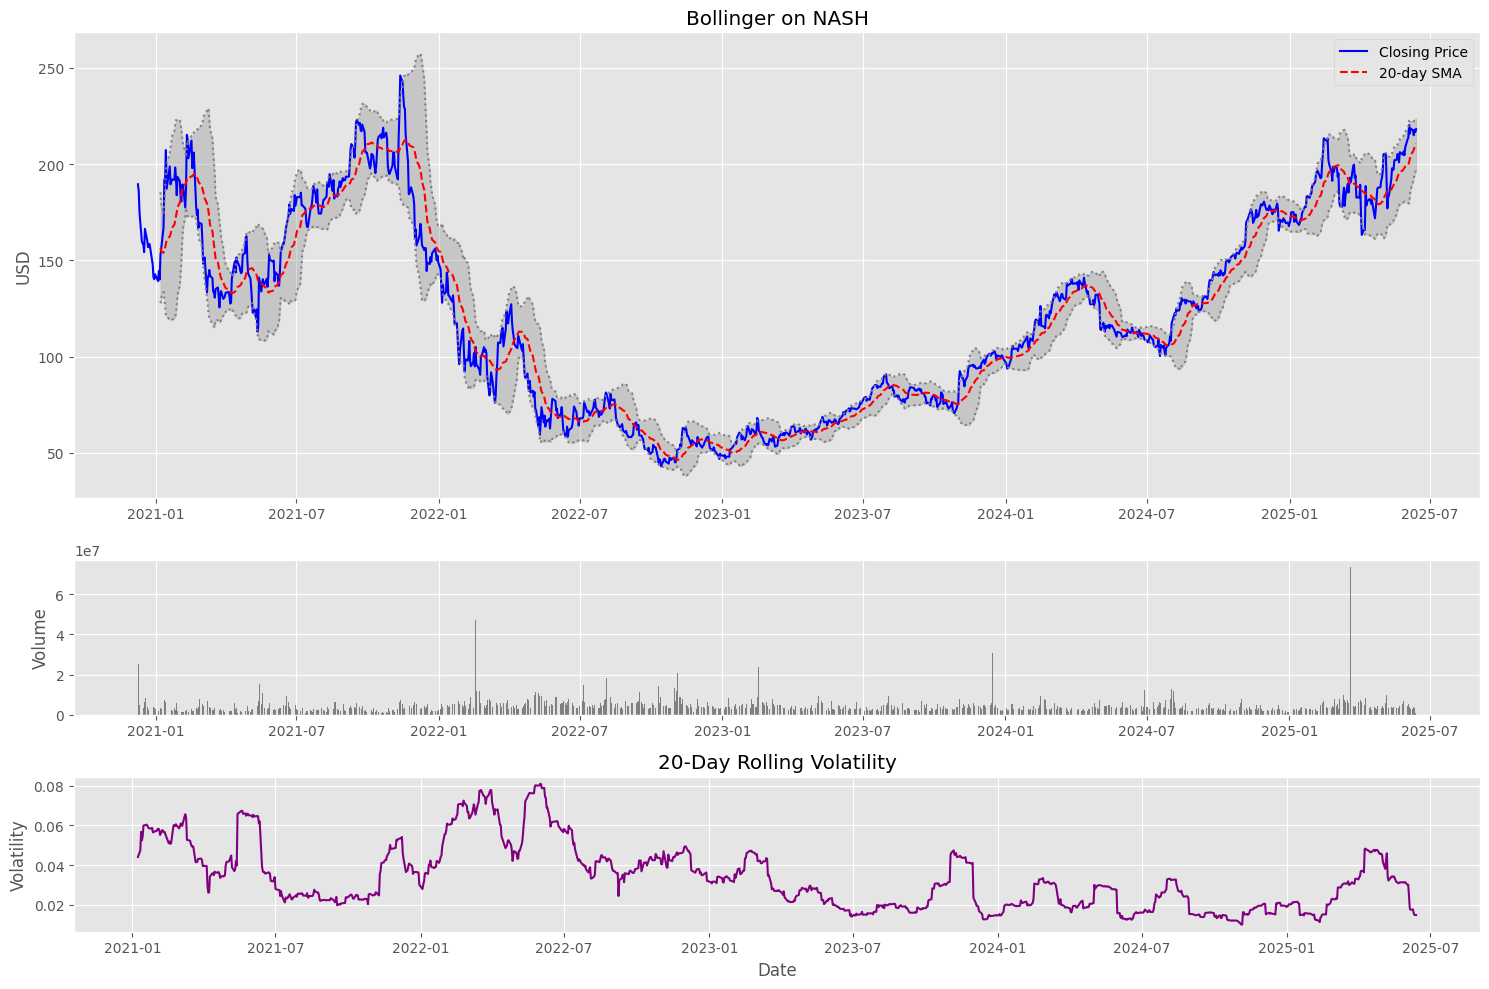

In [16]:
plt.style.use("ggplot")

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,10), gridspec_kw={"height_ratios": [3, 1, 1]})
fig.subplots_adjust(hspace=0.3)

ax1.set_title("Bollinger on NASH")
ax1.set_ylabel("USD")
ax1.plot(df.Close, label = "Closing Price", color = "blue")
ax1.plot(df.SMA_20, label="20-day SMA", color = "red", linestyle ="--")
ax1.plot(df.HighBand, color="grey", linestyle =":")
ax1.plot(df.LowBand, color="grey", linestyle =":")
ax1.fill_between(df.index, df.HighBand, df.LowBand, color = "grey", alpha=0.3)
ax1.legend()

ax2.bar(df.index, df["Volume"], label="Volume", color="grey")
ax2.set_ylabel("Volume")

ax3.plot(df.Volatility_20, label="20-day Volatility", color="purple")
ax3.set_ylabel("Volatility")
ax3.set_title('20-Day Rolling Volatility')
ax3.set_xlabel("Date")

plt.tight_layout()

2. Plot a histogram of log returns.

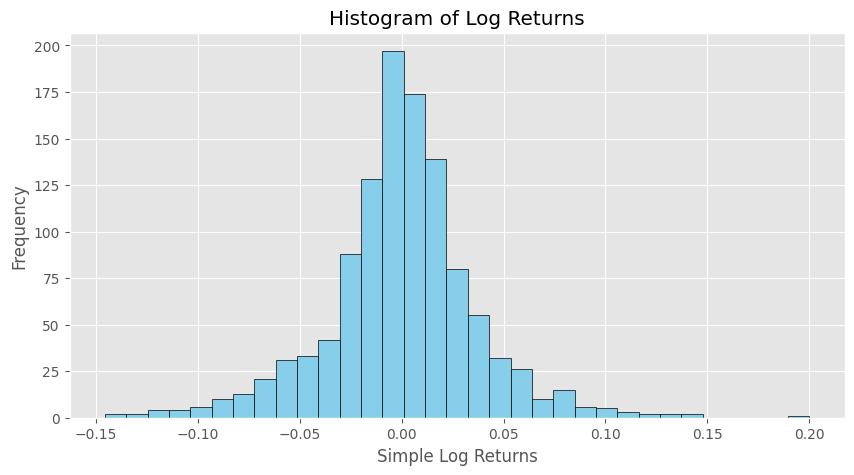

np.float64(2.487712415704242)

In [17]:
recommended_bins = int(np.sqrt(len(df.LogReturns)))
plt.figure(figsize=(10, 5))
plt.hist(df.LogReturns, bins=recommended_bins, color="skyblue", edgecolor="black")

plt.title("Histogram of Log Returns")
plt.xlabel("Simple Log Returns")
plt.ylabel("Frequency")
plt.show()

from scipy.stats import kurtosis
kurtosis(df["LogReturns"].dropna())

3. Construct a scatter plot to explore the relationship between volume and daily returns.

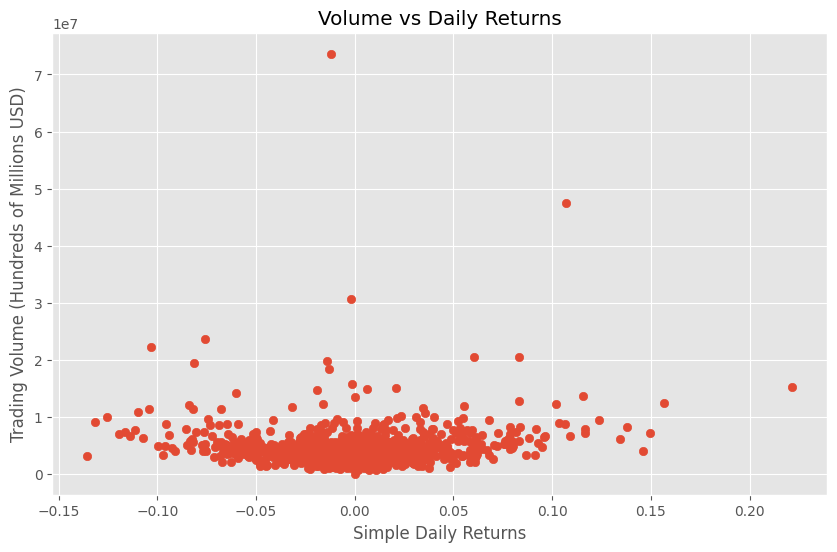

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df.DailyReturns, df.Volume)
plt.title("Volume vs Daily Returns")
plt.ylabel("Trading Volume (Hundreds of Millions USD)")
plt.xlabel("Simple Daily Returns")
plt.show()